# **Custom Inception-ResNet network for eye-tracking**

In this notebook, I designed an optimized network for eye-tracking. The reason that I am focusing on optimized network is that I want to run this model on Raspberry Pi, so I prefer a light network and in the same time with good performance. That is why I decided to make a custom version of Inception and ResNet neural network

The dataset consists of 5000 images, gathered by different cameras.

Tracking is done by two red dots at left and right side if the iris. The input is the image of the whole face and the output is just the area around the eyes with two red dots on two sides of the iris.

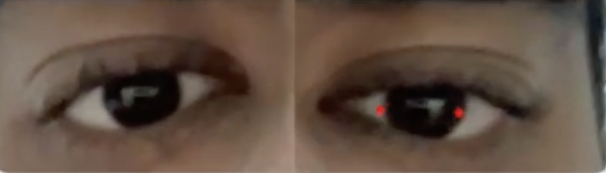

Sample Output

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import random

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip -q "/content/drive/My Drive/Final_Bachelor_Project/NewVersion/dataset/5k_2points_ds.zip" -d "/content/dataset"

In [ ]:
labels_path = '/content/dataset/5k_2points_ds/labels'
images_path = '/content/dataset/5k_2points_ds/images'

In [ ]:
class CustomDataset(object):
    def __init__(self, images_path, labels_path, img_size = [224, 64]):
        self.images = self._load_and_process_images(images_path, img_size)
        self.coordinates = self._load_labels(labels_path)
        self.data = list(zip(self.coordinates, self.images))
        self.indices = list(range(len(self.data)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        index = self.indices[idx]
        coordinates, images = self.data[index]
        return (images, np.array(coordinates))


    def _load_and_process_images(self, base_dir, img_size = [224, 64]):
        """Loads, preprocesses, and returns images as a list.

          Args:
            base_dir: Path to the directory containing image files.
            img_size: Target image size as a list of two integers (height, width).

          Returns:
            A list of preprocessed TensorFlow images.
          """

        images = []
        for root, _, files in os.walk(base_dir):
            for name in files:
                if name.endswith('.jpeg'):
                    file_path = os.path.join(root, name)
                try:
                    image = tf.keras.preprocessing.image.load_img(file_path, target_size=img_size)
                    image_arr = tf.keras.preprocessing.image.img_to_array(image)
                    image_arr = tf.cast(image_arr / 255.0, tf.float32)
                    images.append(image_arr)
                except FileNotFoundError:
                    print(f"Error: File not found - {file_path}")
        return images



    def _load_labels(self, base_dir):
        """Loads labels from text files in a directory.

          Args:
            base_dir: Path to the directory containing coordinate files.

          Returns:
            A list of lists, where each inner list contains integer coordinates
                from a single file.
        """
        coordinates = list()
        for root, _, files in os.walk(base_dir):
            for name in sorted(files):
                if 'txt' in name:
                    file_path = os.path.join(root, name)
                    current_file_coords = list()
                    with open(file_path, 'r') as f:
                        lines = f.read().splitlines()

                    for coord in lines[:-1]:
                        arr = coord.split(',')
                        arr = list(map(int, arr))
                        for item in arr:
                            current_file_coords.append(item)
                    coordinates.append(current_file_coords)

        return coordinates

    def _shuffle_data(self):
        random.shuffle(self.data)

In [ ]:
import tensorflow as tf


def create_tf_dataset(dataset, batch_size=32, shuffle=True):
  """Creates a TensorFlow dataset from a CustomDataset.

  Args:
    dataset: A CustomDataset instance.
    batch_size: The batch size for the dataset.
    shuffle: Whether to shuffle the dataset.

  Returns:
    A TensorFlow dataset.
  """

  def generator():
    for item in dataset:
      yield item

  tf_dataset = tf.data.Dataset.from_generator(
      generator,
      output_types=(tf.float32, tf.int32),  
      output_shapes=([224, 64, 3], [4]))

  if shuffle:
    tf_dataset = tf_dataset.shuffle(buffer_size=len(dataset))

  tf_dataset = tf_dataset.batch(batch_size)
  tf_dataset = tf_dataset.prefetch(tf.data.AUTOTUNE)

  return tf_dataset


In [ ]:
dataset = CustomDataset(images_path, labels_path)
tf_dataset = create_tf_dataset(dataset, batch_size=32)

In [ ]:
def train_val_split(tf_dataset):

    tf_dataset = tf_dataset.cache()
    dataset_size = len(list(tf_dataset.as_numpy_iterator()))
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size

    
    train_dataset = tf_dataset.take(train_size)


    val_dataset = tf_dataset.skip(train_size)

    return train_dataset, val_dataset


train_ds, val_ds = train_val_split(tf_dataset)

In [ ]:
import tensorflow as tf


class InceptionResNetBlock:
    def __init__(self, filters, kernel_size1, kernel_size2, activation='relu', regulizer_lambda=0.03):
        self.filters = filters
        self.kernel_size1 = kernel_size1
        self.kernel_size2 = kernel_size2
        self.activation = activation
        self.regulizer_lambda = regulizer_lambda

    def build_inception_block(self, inputs):
        """
        Builds an inception block with two convolutional branches and concatenates the results.
        """
        x = tf.keras.layers.Conv2D(self.filters, (1, 1), activation=self.activation)(inputs)

        conv1 = tf.keras.layers.Conv2D(self.filters, self.kernel_size1, activation=self.activation, padding='same',
                                       kernel_regularizer=tf.keras.regularizers.L1(self.regulizer_lambda))(x)

        conv2 = tf.keras.layers.Conv2D(self.filters, self.kernel_size2, activation=self.activation, padding='same',
                                       kernel_regularizer=tf.keras.regularizers.L1(self.regulizer_lambda))(x)

        x = tf.keras.layers.Concatenate()([x, conv1, conv2])

        return x

    def build_resnet_block(self, x, kernel_size):
        """
        Builds a residual block with two convolutional layers, a skip connection, and batch normalization.
        """
        x_skip = x  # Skip connection

        x = tf.keras.layers.Conv2D(self.filters, kernel_size, padding='same', activation=self.activation,
                                   kernel_regularizer=tf.keras.regularizers.L1(self.regulizer_lambda))(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv2D(self.filters, kernel_size, padding='same', activation=self.activation,
                                   kernel_regularizer=tf.keras.regularizers.L1(self.regulizer_lambda))(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Add()([x, x_skip])  # Skip connection
        x = tf.keras.layers.Activation('relu')(x)

        return x

    def build_complete_block(self, inputs):
        """
        Builds a complete block combining the inception block and residual blocks.
        """
        # First Convolutional Layer
        x = tf.keras.layers.Conv2D(self.filters, (1, 1), activation=self.activation)(inputs)

        # First Branch
        conv1 = tf.keras.layers.Conv2D(self.filters, self.kernel_size1, activation=self.activation, padding='same',
                                       kernel_regularizer=tf.keras.regularizers.L1(self.regulizer_lambda))(x)
        res_block1 = self.build_resnet_block(conv1, self.kernel_size1)
        conv2 = tf.keras.layers.Conv2D(self.filters // 2, self.kernel_size1, activation=self.activation, padding='same',
                                       kernel_regularizer=tf.keras.regularizers.L1(self.regulizer_lambda))(res_block1)
        b1 = tf.keras.layers.BatchNormalization()(conv2)

        # Second Branch
        conv3 = tf.keras.layers.Conv2D(self.filters, self.kernel_size2, activation=self.activation, padding='same',
                                       kernel_regularizer=tf.keras.regularizers.L1(self.regulizer_lambda))(x)
        res_block2 = self.build_resnet_block(conv3, self.kernel_size2)
        conv4 = tf.keras.layers.Conv2D(self.filters // 2, self.kernel_size2, activation=self.activation, padding='same',
                                       kernel_regularizer=tf.keras.regularizers.L1(self.regulizer_lambda))(res_block2)
        b2 = tf.keras.layers.BatchNormalization()(conv4)

        # Concatenate the input and the two branches
        x = tf.keras.layers.Concatenate()([x, b1, b2])

        return x


# Input layer
inputs = tf.keras.layers.Input(shape=(224, 64, 3))

# Block 1: Inception Block
block_class = InceptionResNetBlock(filters=8, kernel_size1=(3, 3), kernel_size2=(5, 5), activation='relu', regulizer_lambda=0.7)
block1 = block_class.build_inception_block(inputs)
pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(block1)

# Block 2: Complete Block
block_class = InceptionResNetBlock(filters=8, kernel_size1=(3, 3), kernel_size2=(5, 5), activation='relu', regulizer_lambda=0.01)
block2 = block_class.build_complete_block(pool_1)
pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(block2)

# Block 3: Complete Block with different lambda
block_class = InceptionResNetBlock(filters=8, kernel_size1=(3, 3), kernel_size2=(5, 5), activation='relu', regulizer_lambda=0.4)
block3 = block_class.build_complete_block(pool_2)
pool_3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(block3)

# Dropout layer
dp = tf.keras.layers.Dropout(0.5)(pool_3)

# Block 4: Complete Block
block4 = block_class.build_complete_block(dp)

# Block 5: Another Complete Block
block5 = block_class.build_complete_block(block4)
pool_4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(block5)

# Block 6: Inception Block
block_class = InceptionResNetBlock(filters=8, kernel_size1=(3, 3), kernel_size2=(5, 5), activation='relu', regulizer_lambda=0.4)
block6 = block_class.build_inception_block(pool_4)

# Block 7: Another Inception Block
block7 = block_class.build_inception_block(block6)

# Flattening the output
x = tf.keras.layers.Flatten()(block7)

# Output layer (Dense with 4 outputs as per your requirement)
y2_output = tf.keras.layers.Dense(4)(x)

# Defining the model
model = tf.keras.Model(inputs=inputs, outputs=y2_output)

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 64, 3)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 224, 64, 8)     │             32 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 224, 64, 8)     │            584 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 224, 64, 8)     │          1,608 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 224, 64, 24)    │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_1[0][0],        │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 112, 32, 24)    │              0 │ concatenate[0][0]      │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 112, 32, 8)     │            200 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 112, 32, 8)     │            584 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 112, 32, 8)     │          1,608 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 112, 32, 8)     │            584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 112, 32, 8)     │          1,608 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 32, 8)     │             32 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 112, 32, 8)     │             32 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 112, 32, 8)     │            584 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 112, 32, 8)     │          1,608 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 112, 32, 8)     │             32 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 44,260 (172.89 KB)

 Trainable params: 43,940 (171.64 KB)

 Non-trainable params: 320 (1.25 KB)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer = Adam(learning_rate= 0.001),
              loss = 'mse')

In [ ]:
history = model.fit(train_ds,
                    validation_data = val_ds,
                    batch_size = 32,
                    epochs = 50)

Epoch 1/50
    112/Unknown 47s 33ms/step - loss: 18194.1504

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


112/112 ━━━━━━━━━━━━━━━━━━━━ 59s 139ms/step - loss: 18104.9727 - val_loss: 18826.7305
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 1803.7620 - val_loss: 6294.5586
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 1765.6696 - val_loss: 2430.6606
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1742.3701 - val_loss: 1953.5764
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 1714.4634 - val_loss: 2349.7361
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1700.5345 - val_loss: 2188.8599
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1657.9253 - val_loss: 2135.4045
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 1631.3020 - val_loss: 2625.4341
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1615.6058 - val_loss: 2076.6970
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 1581.1052 - val_loss: 2834.4998
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 1570.0647 - va

In [ ]:
data = history.history

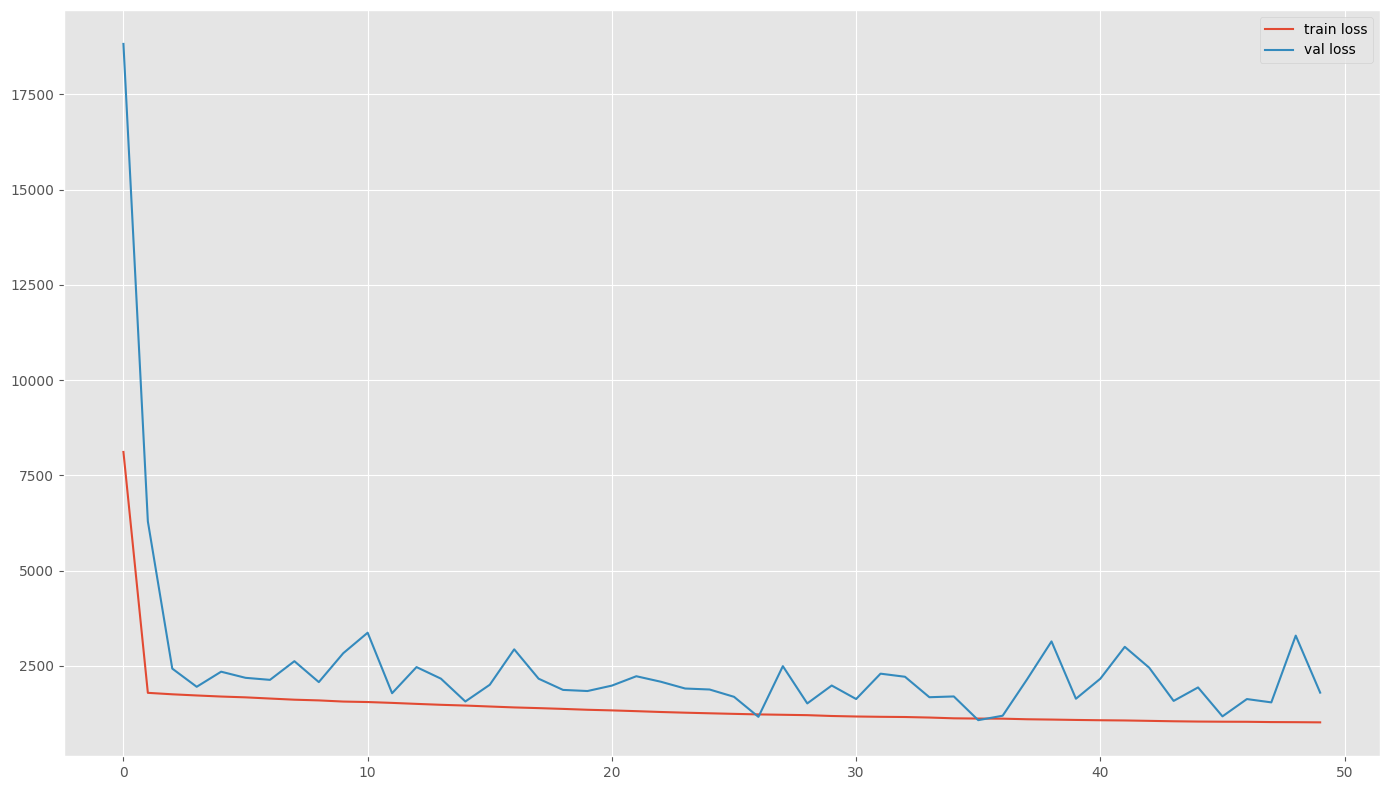

In [ ]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(14,8))
ax.plot(data['loss'], label = 'train loss')
ax.plot(data['val_loss'], label = 'val loss')
fig.tight_layout()
ax.legend()
plt.show()

Because First three loss values are so high, we cannot see the exact trend that both losses have. Thus, I remove the first 3 loss values and then plot the loss values again

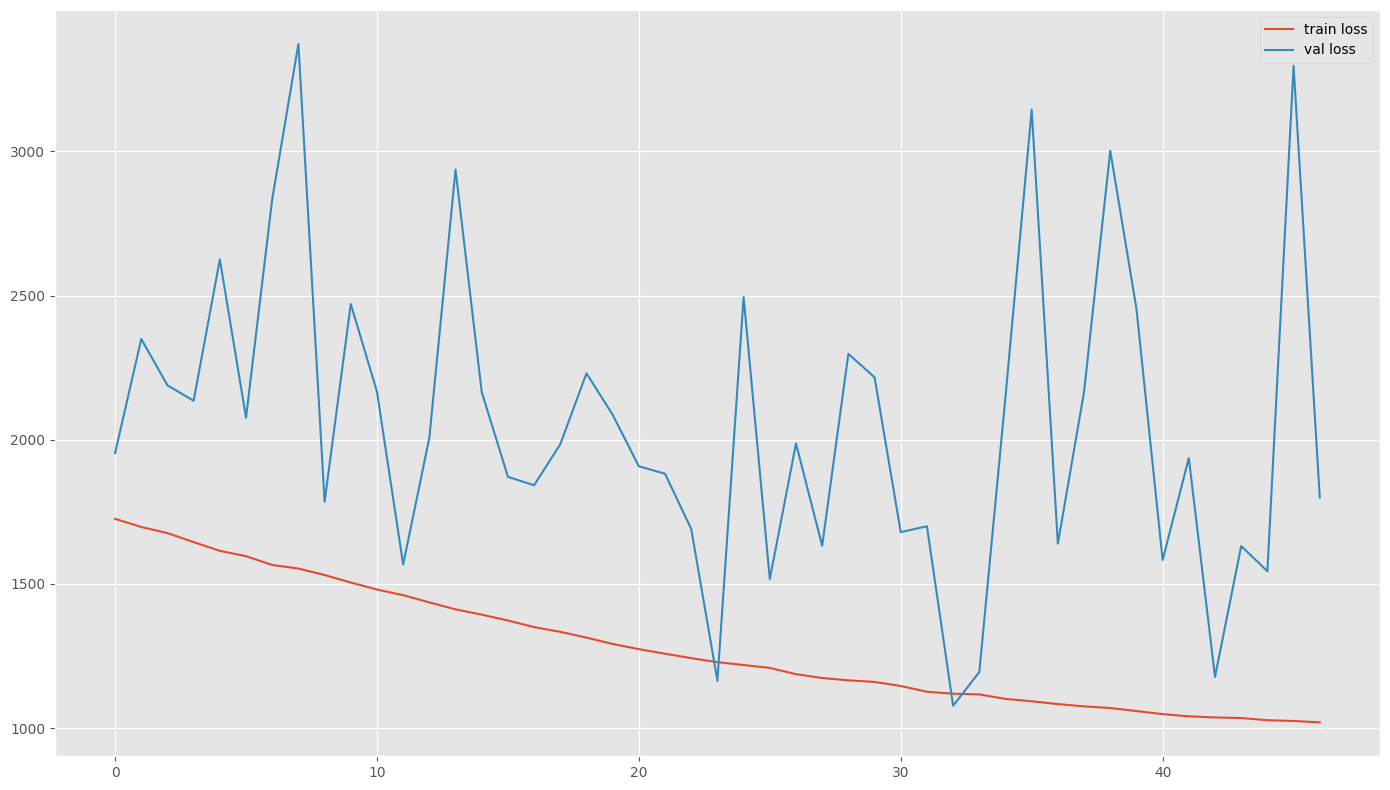

In [ ]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(14,8))
ax.plot(data['loss'][3:], label = 'train loss')
ax.plot(data['val_loss'][3:], label = 'val loss')
fig.tight_layout()
ax.legend()
plt.show()

Based on the plots, I can say the best result happens at the epoch number 46

Epoch 46/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 1044.2153 - val_loss: 1177.4548

Now that we know that we should use the weights at the epoch 46, we load the weights at this epoch and then we test how our model works in the real time. It is worth mentioning that because of the time limit for the project, gathering more data is off the table. Hence, first, we need to focus that our model is as light as possible with the lowest possible of neurons and then we want a model that can predict the movement of eye approximately.

To test the result, we used the Raspberry Pi board with the camera in different situations. The result is satisfying because

1.   the constraint of low number of neurons is respected
2.   the network is fast
3.   the model accuracy with respect to the constraint is really good.


Of course, with more time to gather more data we can improve the accuracy but the aim of this project was to detect the movement of eye using an optimized network and the goal is achieved.



